<a href="https://colab.research.google.com/github/sihabuddinrifqi/Aplikasi-Login/blob/main/forecaasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# di Colab
!pip install -q tensorflow pandas scikit-learn matplotlib openpyxl joblib


In [8]:
# 0) import & helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from datetime import timedelta

# ----- helper functions -----
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred, eps=1e-8):
    # hindari pembagian dengan 0
    y_true_safe = np.where(y_true == 0, eps, y_true)
    return np.mean(np.abs((y_true_safe - y_pred) / y_true_safe)) * 100


In [10]:
# 1) Load dataset
df = pd.read_excel('/content/harga_telur_fix.xlsx')  # upload file ke Colab dulu

# Normalisasi nama kolom sederhana
df.columns = [c.strip() for c in df.columns]

# coba cari kolom tanggal & harga
if 'Tanggal' in df.columns and 'Harga_Telur' in df.columns:
    date_col = 'Tanggal'; price_col = 'Harga_Telur'
else:
    # fallback: cari kolom yang mirip
    possible_dates = [c for c in df.columns if 'tanggal' in c.lower() or 'date' in c.lower()]
    possible_prices = [c for c in df.columns if 'harga' in c.lower() or 'price' in c.lower() or 'telur' in c.lower()]
    if possible_dates:
        date_col = possible_dates[0]
    else:
        raise ValueError("Tidak menemukan kolom tanggal. Pastikan ada kolom tanggal.")
    if possible_prices:
        price_col = possible_prices[0]
    else:
        raise ValueError("Tidak menemukan kolom harga telur. Pastikan ada kolom harga.")

print("Tanggal col =", date_col, ", Harga col =", price_col)

Tanggal col = Tanggal , Harga col = Harga


In [11]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df = df.sort_values('Tanggal').reset_index(drop=True)

In [12]:
# Baca dataset
df = pd.read_excel("harga_telur_fix.xlsx")

# Pastikan nama kolom sesuai
df = df.rename(columns={"Telur Ayam Ras": "Harga"})  # kalau sudah diganti abaikan saja

# Ubah nilai 0 jadi NaN
df["Harga"] = df["Harga"].replace(0, np.nan)

# Tambahkan kolom Tahun dan Bulan
df["Tanggal"] = pd.to_datetime(df["Tanggal"])
df["Tahun"] = df["Tanggal"].dt.year
df["Bulan"] = df["Tanggal"].dt.month

# Isi NaN dengan median per bulan
df["Harga"] = df.groupby(["Tahun", "Bulan"])["Harga"].transform(
    lambda x: x.fillna(x.median())
)

# Hapus kolom Tahun dan Bulan (opsional)
df = df.drop(columns=["Tahun", "Bulan"])

# Simpan kembali dataset hasil cleaning
df.to_excel("harga_telur_clean.xlsx", index=False)

print("Cleaning selesai, data tersimpan di harga_telur_clean.xlsx")


Cleaning selesai, data tersimpan di harga_telur_clean.xlsx


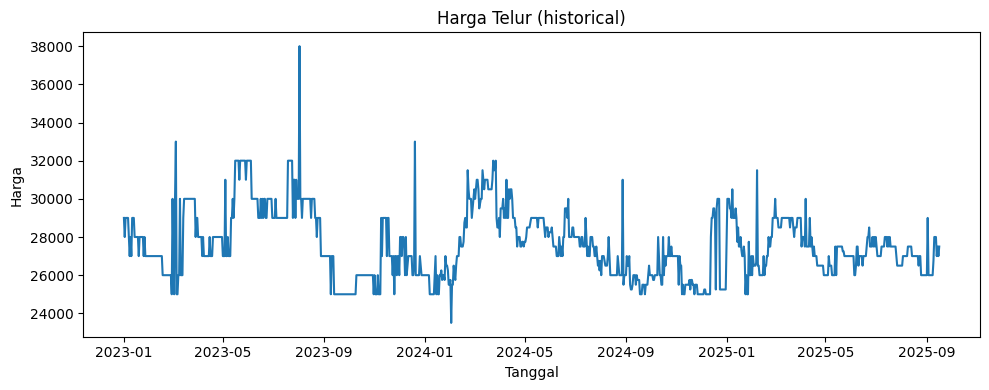

In [13]:
# 3) EDA singkat (plot)
plt.figure(figsize=(10,4))
plt.plot(df['Tanggal'], df['Harga'])
plt.title('Harga Telur (historical)')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.tight_layout()
plt.show()

In [14]:
# 4) Preprocessing: scaling
scaler = MinMaxScaler(feature_range=(0,1))
prices = df['Harga'].values.reshape(-1,1)
prices_scaled = scaler.fit_transform(prices)

# simpan scaler untuk deployment
joblib.dump(scaler, 'scaler_telur.save')


['scaler_telur.save']

In [15]:
# 5) Buat sequences (hyperparam: window_size)
window_size = 30  # input pakai 30 hari terakhir -> tunable
X, y = create_sequences(prices_scaled.flatten(), window_size)

# reshape X untuk LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# 6) Train-test split (time-based)
test_ratio = 0.2
split_index = int(len(X) * (1 - test_ratio))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

print("Train samples:", X_train.shape[0], "Test samples:", X_test.shape[0])


Train samples: 768 Test samples: 192


In [33]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# --- Asumsi variabel ini sudah didefinisikan sebelumnya ---
# window_size = 30 # contoh ukuran window

# Reproducibility
tf.random.set_seed(42)

model = Sequential([
    Bidirectional(
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        input_shape=(window_size, 1)
    ),
    LayerNormalization(), # Menstabilkan aktivasi dan gradien di dalam LSTM
    Dropout(0.3),

    # Layer 2: LSTM biasa dengan Layer Normalization & Regularisasi L2
    LSTM(32, return_sequences=False, kernel_regularizer=l2(0.001)),
    LayerNormalization(),
    Dropout(0.3),

    # Layer 3: Dense dengan Regularisasi L2
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),

    # Layer output
    Dense(1)
])

# Optimizer tetap sama, sudah cukup baik
optimizer = Adam(learning_rate=0.0002)

# Kompilasi model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Tampilkan ringkasan arsitektur model
model.summary()

# --- Tambahan Callbacks (Sangat direkomendasikan) ---
# EarlyStopping untuk menghentikan training lebih awal
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint untuk menyimpan model terbaik
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# ReduceLROnPlateau untuk menurunkan learning rate saat stagnan
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 30, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 30, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_5           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,265 (215.88 KB)

 Trainable params: 55,265 (215.88 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Asumsikan model, X_train, dan y_train sudah ada
# model = Sequential([...])

# 1. Definisikan semua callback
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

# 2. Compile model Anda
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# 3. Latih model dengan menyertakan list callback
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=32,
    callbacks=[es, mc, rlr], # Gunakan variabel callback yang sudah dibuat
    verbose=1
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.4047 - mae: 0.3554
Epoch 1: val_loss improved from inf to 0.15814, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.3989 - mae: 0.3505 - val_loss: 0.1581 - val_mae: 0.0783 - learning_rate: 0.0010
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1785 - mae: 0.1358
Epoch 2: val_loss improved from 0.15814 to 0.15030, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1784 - mae: 0.1358 - val_loss: 0.1503 - val_mae: 0.0717 - learning_rate: 0.0010
Epoch 3/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1621 - mae: 0.1132
Epoch 3: val_loss improved from 0.15030 to 0.14322, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1618 - mae: 0.1128 - val_loss: 0.1432 - val_mae: 0.0710 - learning_rate: 0.0010
Epoch 4/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1487 - mae: 0.0992
Epoch 4: val_loss improved from 0.14322 to 0.13595, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1488 - mae: 0.0998 - val_loss: 0.1360 - val_mae: 0.0681 - learning_rate: 0.0010
Epoch 5/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1420 - mae: 0.0991
Epoch 5: val_loss improved from 0.13595 to 0.13032, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1418 - mae: 0.0990 - val_loss: 0.1303 - val_mae: 0.0781 - learning_rate: 0.0010
Epoch 6/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1316 - mae: 0.0891
Epoch 6: val_loss improved from 0.13032 to 0.12549, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1317 - mae: 0.0897 - val_loss: 0.1255 - val_mae: 0.0874 - learning_rate: 0.0010
Epoch 7/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1279 - mae: 0.0942
Epoch 7: val_loss improved from 0.12549 to 0.11735, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.1275 - mae: 0.0940 - val_loss: 0.1173 - val_mae: 0.0739 - learning_rate: 0.0010
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1179 - mae: 0.0885
Epoch 8: val_loss improved from 0.11735 to 0.11119, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1179 - mae: 0.0885 - val_loss: 0.1112 - val_mae: 0.0710 - learning_rate: 0.0010
Epoch 9/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1117 - mae: 0.0817
Epoch 9: val_loss improved from 0.11119 to 0.10684, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1117 - mae: 0.0822 - val_loss: 0.1068 - val_mae: 0.0751 - learning_rate: 0.0010
Epoch 10/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1066 - mae: 0.0807
Epoch 10: val_loss improved from 0.10684 to 0.10121, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1066 - mae: 0.0810 - val_loss: 0.1012 - val_mae: 0.0697 - learning_rate: 0.0010
Epoch 11/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1008 - mae: 0.0768
Epoch 11: val_loss improved from 0.10121 to 0.09767, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1009 - mae: 0.0772 - val_loss: 0.0977 - val_mae: 0.0722 - learning_rate: 0.0010
Epoch 12/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0960 - mae: 0.0757
Epoch 12: val_loss improved from 0.09767 to 0.09322, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0960 - mae: 0.0759 - val_loss: 0.0932 - val_mae: 0.0733 - learning_rate: 0.0010
Epoch 13/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0921 - mae: 0.0760
Epoch 13: val_loss improved from 0.09322 to 0.09034, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0921 - mae: 0.0763 - val_loss: 0.0903 - val_mae: 0.0776 - learning_rate: 0.0010
Epoch 14/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0880 - mae: 0.0749
Epoch 14: val_loss improved from 0.09034 to 0.08563, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0880 - mae: 0.0748 - val_loss: 0.0856 - val_mae: 0.0713 - learning_rate: 0.0010
Epoch 15/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0835 - mae: 0.0698
Epoch 15: val_loss improved from 0.08563 to 0.08261, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0835 - mae: 0.0699 - val_loss: 0.0826 - val_mae: 0.0739 - learning_rate: 0.0010
Epoch 16/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0796 - mae: 0.0676
Epoch 16: val_loss improved from 0.08261 to 0.07995, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0796 - mae: 0.0679 - val_loss: 0.0799 - val_mae: 0.0761 - learning_rate: 0.0010
Epoch 17/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0765 - mae: 0.0669
Epoch 17: val_loss improved from 0.07995 to 0.07652, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0765 - mae: 0.0672 - val_loss: 0.0765 - val_mae: 0.0733 - learning_rate: 0.0010
Epoch 18/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0733 - mae: 0.0650
Epoch 18: val_loss improved from 0.07652 to 0.07304, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0734 - mae: 0.0655 - val_loss: 0.0730 - val_mae: 0.0695 - learning_rate: 0.0010
Epoch 19/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0704 - mae: 0.0636
Epoch 19: val_loss improved from 0.07304 to 0.07121, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0704 - mae: 0.0639 - val_loss: 0.0712 - val_mae: 0.0729 - learning_rate: 0.0010
Epoch 20/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0679 - mae: 0.0639
Epoch 20: val_loss improved from 0.07121 to 0.06885, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0680 - mae: 0.0640 - val_loss: 0.0689 - val_mae: 0.0734 - learning_rate: 0.0010
Epoch 21/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0655 - mae: 0.0623
Epoch 21: val_loss improved from 0.06885 to 0.06619, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0655 - mae: 0.0624 - val_loss: 0.0662 - val_mae: 0.0710 - learning_rate: 0.0010
Epoch 22/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0628 - mae: 0.0635
Epoch 22: val_loss improved from 0.06619 to 0.06400, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0628 - mae: 0.0636 - val_loss: 0.0640 - val_mae: 0.0698 - learning_rate: 0.0010
Epoch 23/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0606 - mae: 0.0629
Epoch 23: val_loss improved from 0.06400 to 0.06197, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0606 - mae: 0.0630 - val_loss: 0.0620 - val_mae: 0.0707 - learning_rate: 0.0010
Epoch 24/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0578 - mae: 0.0581
Epoch 24: val_loss improved from 0.06197 to 0.06151, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0579 - mae: 0.0584 - val_loss: 0.0615 - val_mae: 0.0797 - learning_rate: 0.0010
Epoch 25/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0565 - mae: 0.0621
Epoch 25: val_loss improved from 0.06151 to 0.05831, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0565 - mae: 0.0623 - val_loss: 0.0583 - val_mae: 0.0716 - learning_rate: 0.0010
Epoch 26/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0548 - mae: 0.0628
Epoch 26: val_loss improved from 0.05831 to 0.05618, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0548 - mae: 0.0629 - val_loss: 0.0562 - val_mae: 0.0693 - learning_rate: 0.0010
Epoch 27/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0529 - mae: 0.0608
Epoch 27: val_loss improved from 0.05618 to 0.05482, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0529 - mae: 0.0611 - val_loss: 0.0548 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 28/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0506 - mae: 0.0580
Epoch 28: val_loss improved from 0.05482 to 0.05305, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0507 - mae: 0.0582 - val_loss: 0.0531 - val_mae: 0.0696 - learning_rate: 0.0010
Epoch 29/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0491 - mae: 0.0549
Epoch 29: val_loss improved from 0.05305 to 0.05171, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0492 - mae: 0.0555 - val_loss: 0.0517 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 30/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0478 - mae: 0.0586
Epoch 30: val_loss improved from 0.05171 to 0.05011, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0478 - mae: 0.0587 - val_loss: 0.0501 - val_mae: 0.0701 - learning_rate: 0.0010
Epoch 31/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0458 - mae: 0.0546
Epoch 31: val_loss improved from 0.05011 to 0.04933, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0459 - mae: 0.0551 - val_loss: 0.0493 - val_mae: 0.0726 - learning_rate: 0.0010
Epoch 32/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0449 - mae: 0.0550
Epoch 32: val_loss improved from 0.04933 to 0.04733, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0450 - mae: 0.0554 - val_loss: 0.0473 - val_mae: 0.0684 - learning_rate: 0.0010
Epoch 33/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0435 - mae: 0.0558
Epoch 33: val_loss improved from 0.04733 to 0.04615, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0436 - mae: 0.0563 - val_loss: 0.0461 - val_mae: 0.0688 - learning_rate: 0.0010
Epoch 34/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0420 - mae: 0.0531
Epoch 34: val_loss improved from 0.04615 to 0.04513, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0421 - mae: 0.0532 - val_loss: 0.0451 - val_mae: 0.0690 - learning_rate: 0.0010
Epoch 35/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0408 - mae: 0.0532
Epoch 35: val_loss improved from 0.04513 to 0.04445, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0409 - mae: 0.0538 - val_loss: 0.0445 - val_mae: 0.0703 - learning_rate: 0.0010
Epoch 36/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0398 - mae: 0.0535
Epoch 36: val_loss improved from 0.04445 to 0.04274, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0400 - mae: 0.0543 - val_loss: 0.0427 - val_mae: 0.0680 - learning_rate: 0.0010
Epoch 37/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0387 - mae: 0.0554
Epoch 37: val_loss improved from 0.04274 to 0.04149, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0389 - mae: 0.0559 - val_loss: 0.0415 - val_mae: 0.0663 - learning_rate: 0.0010
Epoch 38/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0378 - mae: 0.0529
Epoch 38: val_loss improved from 0.04149 to 0.04076, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0379 - mae: 0.0533 - val_loss: 0.0408 - val_mae: 0.0688 - learning_rate: 0.0010
Epoch 39/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0368 - mae: 0.0554
Epoch 39: val_loss improved from 0.04076 to 0.03999, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0369 - mae: 0.0557 - val_loss: 0.0400 - val_mae: 0.0692 - learning_rate: 0.0010
Epoch 40/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0361 - mae: 0.0556
Epoch 40: val_loss improved from 0.03999 to 0.03873, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0362 - mae: 0.0560 - val_loss: 0.0387 - val_mae: 0.0653 - learning_rate: 0.0010
Epoch 41/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0349 - mae: 0.0529
Epoch 41: val_loss improved from 0.03873 to 0.03823, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0350 - mae: 0.0535 - val_loss: 0.0382 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 42/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0342 - mae: 0.0520
Epoch 42: val_loss improved from 0.03823 to 0.03706, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0343 - mae: 0.0523 - val_loss: 0.0371 - val_mae: 0.0673 - learning_rate: 0.0010
Epoch 43/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0329 - mae: 0.0506
Epoch 43: val_loss improved from 0.03706 to 0.03641, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0331 - mae: 0.0513 - val_loss: 0.0364 - val_mae: 0.0664 - learning_rate: 0.0010
Epoch 44/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0318 - mae: 0.0485
Epoch 44: val_loss improved from 0.03641 to 0.03533, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0319 - mae: 0.0488 - val_loss: 0.0353 - val_mae: 0.0658 - learning_rate: 0.0010
Epoch 45/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0316 - mae: 0.0514
Epoch 45: val_loss improved from 0.03533 to 0.03516, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0316 - mae: 0.0517 - val_loss: 0.0352 - val_mae: 0.0689 - learning_rate: 0.0010
Epoch 46/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0304 - mae: 0.0494
Epoch 46: val_loss improved from 0.03516 to 0.03408, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0304 - mae: 0.0497 - val_loss: 0.0341 - val_mae: 0.0675 - learning_rate: 0.0010
Epoch 47/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0295 - mae: 0.0494
Epoch 47: val_loss improved from 0.03408 to 0.03306, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0296 - mae: 0.0497 - val_loss: 0.0331 - val_mae: 0.0634 - learning_rate: 0.0010
Epoch 48/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0291 - mae: 0.0496
Epoch 48: val_loss improved from 0.03306 to 0.03257, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0292 - mae: 0.0503 - val_loss: 0.0326 - val_mae: 0.0656 - learning_rate: 0.0010
Epoch 49/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0286 - mae: 0.0517
Epoch 49: val_loss improved from 0.03257 to 0.03241, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0287 - mae: 0.0520 - val_loss: 0.0324 - val_mae: 0.0679 - learning_rate: 0.0010
Epoch 50/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0276 - mae: 0.0501
Epoch 50: val_loss improved from 0.03241 to 0.03132, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0277 - mae: 0.0506 - val_loss: 0.0313 - val_mae: 0.0659 - learning_rate: 0.0010
Epoch 51/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0271 - mae: 0.0497
Epoch 51: val_loss improved from 0.03132 to 0.03067, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0272 - mae: 0.0500 - val_loss: 0.0307 - val_mae: 0.0650 - learning_rate: 0.0010
Epoch 52/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0264 - mae: 0.0488
Epoch 52: val_loss improved from 0.03067 to 0.02994, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0265 - mae: 0.0491 - val_loss: 0.0299 - val_mae: 0.0636 - learning_rate: 0.0010
Epoch 53/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0260 - mae: 0.0483
Epoch 53: val_loss improved from 0.02994 to 0.02928, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0261 - mae: 0.0487 - val_loss: 0.0293 - val_mae: 0.0623 - learning_rate: 0.0010
Epoch 54/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0251 - mae: 0.0480
Epoch 54: val_loss did not improve from 0.02928
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0253 - mae: 0.0485 - val_loss: 0.0296 - val_mae: 0.0674 - learning_rate: 0.0010
Epoch 55/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0256 - mae: 0.0535
Epoch 55: val_loss improved from 0.02928 to 0.02852, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0256 - mae: 0.0537 - val_loss: 0.0285 - val_mae: 0.0651 - learning_rate: 0.0010
Epoch 56/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0245 - mae: 0.0497
Epoch 56: val_loss improved from 0.02852 to 0.02802, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0246 - mae: 0.0498 - val_loss: 0.0280 - val_mae: 0.0651 - learning_rate: 0.0010
Epoch 57/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0240 - mae: 0.0498
Epoch 57: val_loss improved from 0.02802 to 0.02780, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0241 - mae: 0.0501 - val_loss: 0.0278 - val_mae: 0.0667 - learning_rate: 0.0010
Epoch 58/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0234 - mae: 0.0496
Epoch 58: val_loss improved from 0.02780 to 0.02700, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0236 - mae: 0.0501 - val_loss: 0.0270 - val_mae: 0.0637 - learning_rate: 0.0010
Epoch 59/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0229 - mae: 0.0480
Epoch 59: val_loss improved from 0.02700 to 0.02643, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0230 - mae: 0.0482 - val_loss: 0.0264 - val_mae: 0.0646 - learning_rate: 0.0010
Epoch 60/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0230 - mae: 0.0529
Epoch 60: val_loss improved from 0.02643 to 0.02604, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0232 - mae: 0.0531 - val_loss: 0.0260 - val_mae: 0.0634 - learning_rate: 0.0010
Epoch 61/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0218 - mae: 0.0462
Epoch 61: val_loss improved from 0.02604 to 0.02558, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0219 - mae: 0.0469 - val_loss: 0.0256 - val_mae: 0.0639 - learning_rate: 0.0010
Epoch 62/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0216 - mae: 0.0494
Epoch 62: val_loss improved from 0.02558 to 0.02508, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0216 - mae: 0.0495 - val_loss: 0.0251 - val_mae: 0.0630 - learning_rate: 0.0010
Epoch 63/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0206 - mae: 0.0452
Epoch 63: val_loss improved from 0.02508 to 0.02474, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0208 - mae: 0.0460 - val_loss: 0.0247 - val_mae: 0.0636 - learning_rate: 0.0010
Epoch 64/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0210 - mae: 0.0496
Epoch 64: val_loss improved from 0.02474 to 0.02457, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0211 - mae: 0.0497 - val_loss: 0.0246 - val_mae: 0.0633 - learning_rate: 0.0010
Epoch 65/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0202 - mae: 0.0473
Epoch 65: val_loss improved from 0.02457 to 0.02392, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0203 - mae: 0.0478 - val_loss: 0.0239 - val_mae: 0.0630 - learning_rate: 0.0010
Epoch 66/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0201 - mae: 0.0474
Epoch 66: val_loss improved from 0.02392 to 0.02375, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0202 - mae: 0.0478 - val_loss: 0.0238 - val_mae: 0.0642 - learning_rate: 0.0010
Epoch 67/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0192 - mae: 0.0453
Epoch 67: val_loss did not improve from 0.02375
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0193 - mae: 0.0458 - val_loss: 0.0238 - val_mae: 0.0677 - learning_rate: 0.0010
Epoch 68/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0195 - mae: 0.0495
Epoch 68: val_loss improved from 0.02375 to 0.02287, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0196 - mae: 0.0496 - val_loss: 0.0229 - val_mae: 0.0635 - learning_rate: 0.0010
Epoch 69/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0186 - mae: 0.0462
Epoch 69: val_loss improved from 0.02287 to 0.02277, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0187 - mae: 0.0465 - val_loss: 0.0228 - val_mae: 0.0650 - learning_rate: 0.0010
Epoch 70/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0184 - mae: 0.0475
Epoch 70: val_loss improved from 0.02277 to 0.02224, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0185 - mae: 0.0481 - val_loss: 0.0222 - val_mae: 0.0651 - learning_rate: 0.0010
Epoch 71/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0182 - mae: 0.0474
Epoch 71: val_loss improved from 0.02224 to 0.02214, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0183 - mae: 0.0477 - val_loss: 0.0221 - val_mae: 0.0650 - learning_rate: 0.0010
Epoch 72/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0176 - mae: 0.0466
Epoch 72: val_loss improved from 0.02214 to 0.02172, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0177 - mae: 0.0471 - val_loss: 0.0217 - val_mae: 0.0645 - learning_rate: 0.0010
Epoch 73/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0176 - mae: 0.0475
Epoch 73: val_loss improved from 0.02172 to 0.02123, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0177 - mae: 0.0478 - val_loss: 0.0212 - val_mae: 0.0637 - learning_rate: 0.0010
Epoch 74/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0172 - mae: 0.0459
Epoch 74: val_loss improved from 0.02123 to 0.02086, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0173 - mae: 0.0463 - val_loss: 0.0209 - val_mae: 0.0624 - learning_rate: 0.0010
Epoch 75/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0170 - mae: 0.0478
Epoch 75: val_loss improved from 0.02086 to 0.02062, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0170 - mae: 0.0479 - val_loss: 0.0206 - val_mae: 0.0628 - learning_rate: 0.0010
Epoch 76/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0165 - mae: 0.0455
Epoch 76: val_loss improved from 0.02062 to 0.02037, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0165 - mae: 0.0457 - val_loss: 0.0204 - val_mae: 0.0628 - learning_rate: 0.0010
Epoch 77/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0162 - mae: 0.0462
Epoch 77: val_loss improved from 0.02037 to 0.02002, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0163 - mae: 0.0464 - val_loss: 0.0200 - val_mae: 0.0632 - learning_rate: 0.0010
Epoch 78/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0164 - mae: 0.0483
Epoch 78: val_loss did not improve from 0.02002
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0164 - mae: 0.0484 - val_loss: 0.0201 - val_mae: 0.0648 - learning_rate: 0.0010
Epoch 79/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0156 - mae: 0.0452
Epoch 79: val_loss improved from 0.02002 to 0.01950, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0157 - mae: 0.0457 - val_loss: 0.0195 - val_mae: 0.0624 - learning_rate: 0.0010
Epoch 80/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0156 - mae: 0.0460
Epoch 80: val_loss did not improve from 0.01950
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0158 - mae: 0.0467 - val_loss: 0.0195 - val_mae: 0.0653 - learning_rate: 0.0010
Epoch 81/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0153 - mae: 0.0484
Epoch 81: val_loss improved from 0.01950 to 0.01896, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0154 - mae: 0.0487 - val_loss: 0.0190 - val_mae: 0.0618 - learning_rate: 0.0010
Epoch 82/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0147 - mae: 0.0442
Epoch 82: val_loss improved from 0.01896 to 0.01890, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0148 - mae: 0.0446 - val_loss: 0.0189 - val_mae: 0.0631 - learning_rate: 0.0010
Epoch 83/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0146 - mae: 0.0461
Epoch 83: val_loss improved from 0.01890 to 0.01848, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0147 - mae: 0.0465 - val_loss: 0.0185 - val_mae: 0.0616 - learning_rate: 0.0010
Epoch 84/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0143 - mae: 0.0435
Epoch 84: val_loss improved from 0.01848 to 0.01813, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0144 - mae: 0.0442 - val_loss: 0.0181 - val_mae: 0.0607 - learning_rate: 0.0010
Epoch 85/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0142 - mae: 0.0453
Epoch 85: val_loss did not improve from 0.01813
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0142 - mae: 0.0455 - val_loss: 0.0183 - val_mae: 0.0622 - learning_rate: 0.0010
Epoch 86/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0139 - mae: 0.0448
Epoch 86: val_loss improved from 0.01813 to 0.01778, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0140 - mae: 0.0455 - val_loss: 0.0178 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 87/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0136 - mae: 0.0448
Epoch 87: val_loss did not improve from 0.01778
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0137 - mae: 0.0452 - val_loss: 0.0180 - val_mae: 0.0649 - learning_rate: 0.0010
Epoch 88/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0140 - mae: 0.0483
Epoch 88: val_loss improved from 0.01778 to 0.01746, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0141 - mae: 0.0485 - val_loss: 0.0175 - val_mae: 0.0626 - learning_rate: 0.0010
Epoch 89/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0131 - mae: 0.0429
Epoch 89: val_loss improved from 0.01746 to 0.01740, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0132 - mae: 0.0434 - val_loss: 0.0174 - val_mae: 0.0638 - learning_rate: 0.0010
Epoch 90/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0133 - mae: 0.0466
Epoch 90: val_loss improved from 0.01740 to 0.01683, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0133 - mae: 0.0467 - val_loss: 0.0168 - val_mae: 0.0612 - learning_rate: 0.0010
Epoch 91/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0132 - mae: 0.0470
Epoch 91: val_loss did not improve from 0.01683
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0133 - mae: 0.0472 - val_loss: 0.0169 - val_mae: 0.0623 - learning_rate: 0.0010
Epoch 92/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0125 - mae: 0.0434
Epoch 92: val_loss improved from 0.01683 to 0.01671, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0126 - mae: 0.0438 - val_loss: 0.0167 - val_mae: 0.0626 - learning_rate: 0.0010
Epoch 93/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0125 - mae: 0.0448
Epoch 93: val_loss improved from 0.01671 to 0.01653, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0126 - mae: 0.0451 - val_loss: 0.0165 - val_mae: 0.0626 - learning_rate: 0.0010
Epoch 94/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0125 - mae: 0.0466
Epoch 94: val_loss improved from 0.01653 to 0.01650, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0125 - mae: 0.0466 - val_loss: 0.0165 - val_mae: 0.0622 - learning_rate: 0.0010
Epoch 95/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0123 - mae: 0.0441
Epoch 95: val_loss improved from 0.01650 to 0.01613, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0124 - mae: 0.0446 - val_loss: 0.0161 - val_mae: 0.0623 - learning_rate: 0.0010
Epoch 96/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0121 - mae: 0.0463
Epoch 96: val_loss improved from 0.01613 to 0.01613, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0123 - mae: 0.0467 - val_loss: 0.0161 - val_mae: 0.0625 - learning_rate: 0.0010
Epoch 97/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0120 - mae: 0.0448
Epoch 97: val_loss improved from 0.01613 to 0.01560, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0121 - mae: 0.0451 - val_loss: 0.0156 - val_mae: 0.0611 - learning_rate: 0.0010
Epoch 98/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0117 - mae: 0.0442
Epoch 98: val_loss did not improve from 0.01560
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - mae: 0.0445 - val_loss: 0.0156 - val_mae: 0.0610 - learning_rate: 0.0010
Epoch 99/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0119 - mae: 0.0469
Epoch 99: val_loss did not improve from 0.01560
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0119 - mae: 0.0470 - val_loss: 0.0159 - val_mae: 0.0648 - learning_rate: 0.0010
Epoch 100/100
20/22 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0116 - mae: 0.0460
Epoch 100: val_loss improved from 0.01560 to 0.01548, saving model to best_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0117 - mae: 0.0465 - val_loss: 0.0155 - val_mae: 0.0621 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 100.


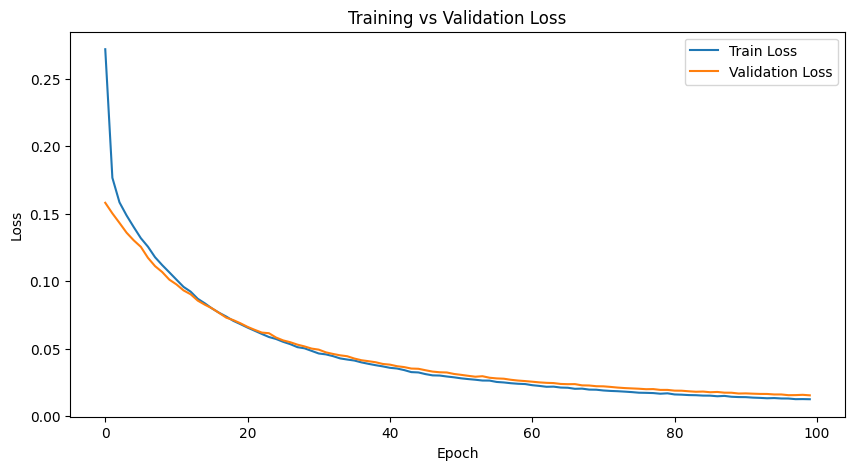

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [36]:
import joblib



# 1. Simpan model Keras
model.save('best_model.h5')

# 2. Simpan objek scaler
joblib.dump(scaler, 'scaler.joblib')

print("Model dan scaler berhasil disimpan!")

Model dan scaler berhasil disimpan!


In [37]:
import numpy as np
import tensorflow as tf

def predict_future(model, initial_sequence, n_steps):
    """
    Fungsi untuk melakukan prediksi multi-langkah ke depan.

    :param model: Model Keras yang sudah dilatih.
    :param initial_sequence: Data awal (scaled) dengan panjang window_size.
    :param n_steps: Jumlah hari yang ingin diprediksi.
    :return: List berisi nilai prediksi (scaled).
    """
    future_preds = []
    current_sequence = initial_sequence.copy()

    for _ in range(n_steps):
        # Reshape sequence agar sesuai dengan input model
        input_data = current_sequence.reshape((1, len(current_sequence), 1))

        # Lakukan prediksi untuk satu langkah ke depan
        next_pred = model.predict(input_data)[0, 0]

        # Simpan hasil prediksi
        future_preds.append(next_pred)

        # Perbarui sequence: tambahkan prediksi baru dan hapus data paling lama
        current_sequence = np.append(current_sequence[1:], next_pred)

    return future_preds